### Forward diffusion of `DDPM`

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch,torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


In [6]:
def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch
def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np
print ("Ready.")

Ready.


### Plot configuration

In [7]:
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5);
print ("Ready")

Ready


### Training data

100%|██████████| 4996278331/4996278331 [07:23<00:00, 11274302.43it/s]


Extracting ../data/food-101.tar.gz to ../data


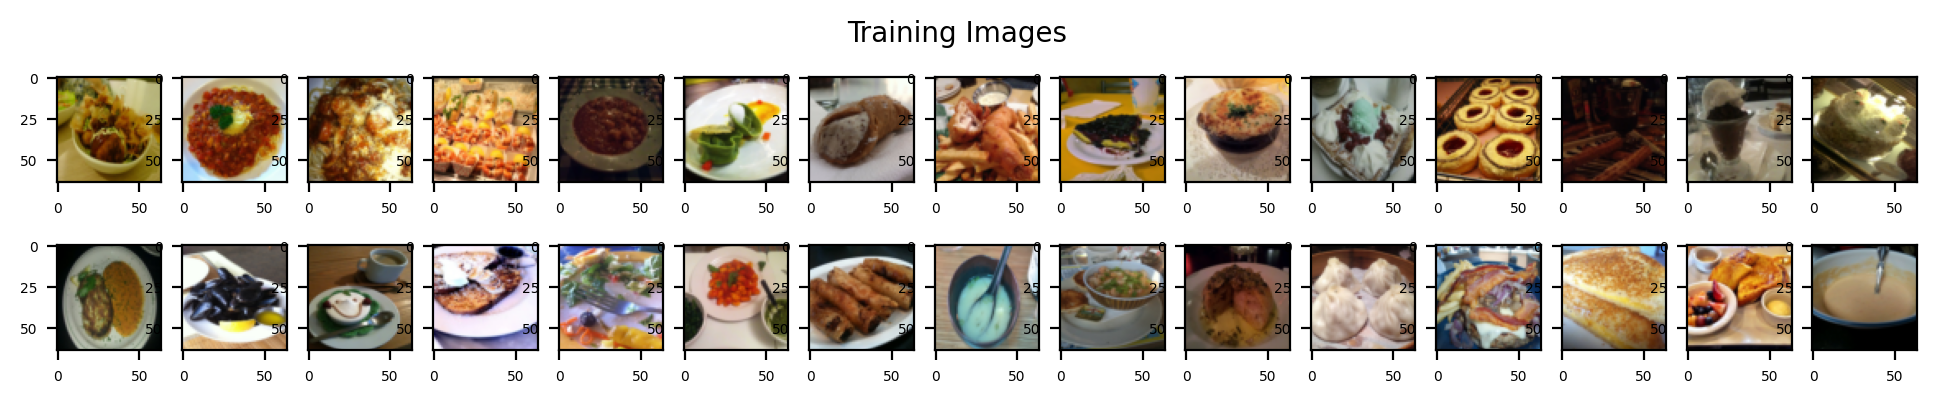

Ready.


In [8]:
trs = [transforms.Resize((64,64)),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor()] # [B x C x H x W]
dataset = torchvision.datasets.Food101(
    root='../data',split='train',transform=transforms.Compose(trs),download=True)
dataloader = DataLoader(dataset=dataset,batch_size=128,shuffle=True,drop_last=True)
n_plot,n_row = 30,2
plt.figure(figsize=(12,2));
for i_idx,img_idx in enumerate(np.random.permutation(len(dataset))[:n_plot]):
    plt.subplot(n_row,n_plot//n_row,i_idx+1)
    plt.imshow(torch2np(dataset[img_idx][0]).transpose([1,2,0]))
plt.suptitle('Training Images',fontsize=10); plt.show()
print ("Ready.")

### DDPM 
`Forward` diffusion process: 
$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$

`Jump` diffusion process: 
$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$ where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

`Reverse` process posterior:
$$ 
q(x_{t-1}|x_t,x_0) = \mathcal{N}
\left(
x_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Default DDPM Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=1,000$ 

Here, we modified $\beta_1$ to be $0.001$ and $\beta_T$ to be $0.01$.

In [9]:
# Precompute some constants for DDPM
dc = {}
dc['T'] = 1000
dc['betas'] = torch.linspace(start=0.001,end=0.01,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")

Ready.


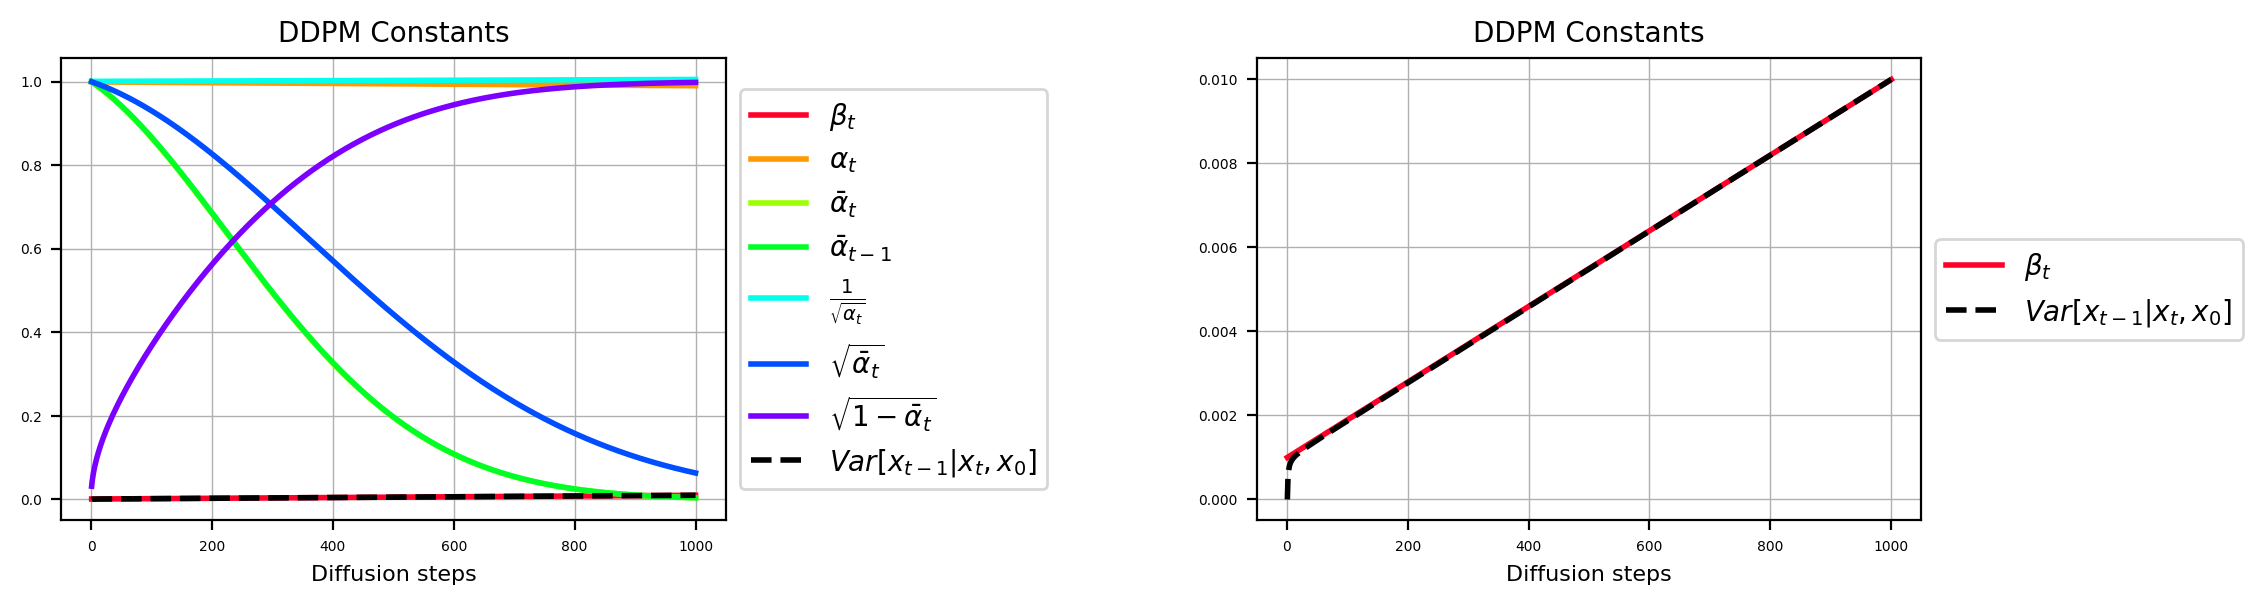

In [10]:
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.8); plt.show()

### Helper function

In [11]:
def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
print ("Ready.")

Ready.


### Forward diffusion sampling for Images

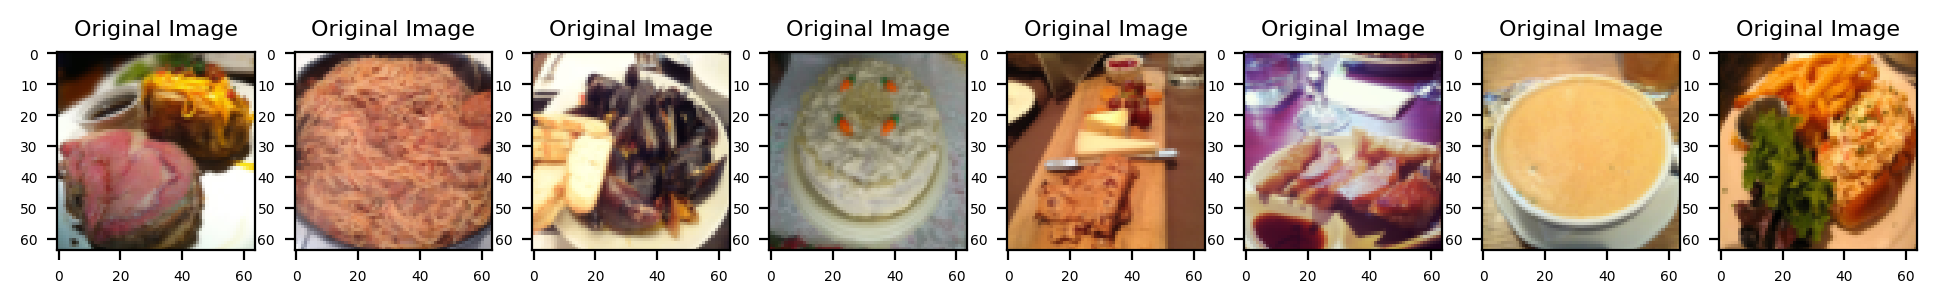

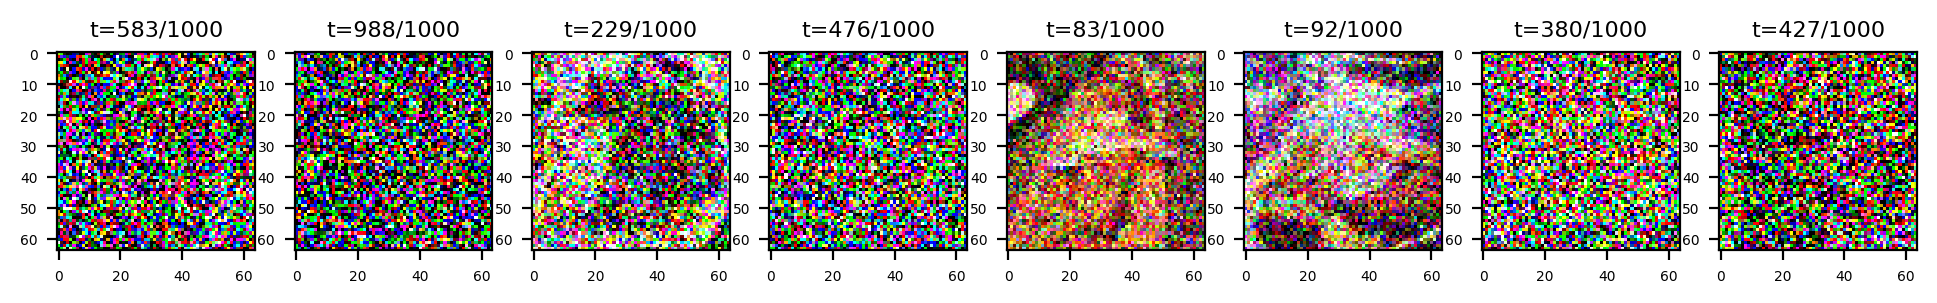

Ready.


In [21]:
x_0 = next(iter(dataloader))[0] # [128 x 3 x 64 x 64]
steps = torch.randint(low=0,high=dc['T'],size=(128,)) # [128]
sqrt_alphas_bar_t = gather_and_reshape(
    values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [128 x 1 x 1 x 1]
sqrt_one_minus_alphas_bar_t = gather_and_reshape(
    values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [128 x 1 x 1 x 1]
x_t_mean = sqrt_alphas_bar_t * x_0 # [128 x 3 x 64 x 64]
x_t_std = sqrt_one_minus_alphas_bar_t # [128 x 3 x 64 x 64]
noise = torch.randn_like(input=x_0) # [128 x 3 x 64 x 64]
x_t = x_t_mean + x_t_std*noise # [128 x 3 x 64 x 64]
x_t = x_t.clip(min=0.0,max=1.0) # clip values between 0.0 to 1.0
# Plot 
n_img = 8
plt.figure(figsize=(12,1.5))
for img_idx in range(n_img):
    plt.subplot(1,n_img,img_idx+1)
    plt.imshow(torch2np(x_0[img_idx]).transpose([1,2,0]))
    plt.title('Original Image',fontsize=8)
plt.show()
plt.figure(figsize=(12,1.5))
for img_idx in range(n_img):
    plt.subplot(1,n_img,img_idx+1)
    plt.imshow(torch2np(x_t[img_idx]).transpose([1,2,0]))
    plt.title('t=%d/%d'%(torch2np(steps[img_idx]),dc['T']),fontsize=8)
plt.show()
print ("Ready.")

`Forward` diffusion process: 

$q(x_t|x_{t-1}) = \mathcal{N}\left(x_t; ~\sqrt{1-\beta_t}x_{t-1}, \beta_t I \right)$

$q(x_t|x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I \right)$ where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

### Forward diffusion batch sampling 

In [22]:
def forward_diffusion_sample(x_0,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x C x H x W] or [B x D x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape)
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape)
    x_t_mean = sqrt_alphas_bar_t * x_0
    x_t_std = sqrt_one_minus_alphas_bar_t
    noise = torch.randn_like(input=x_0)
    x_t = x_t_mean + noise_rate*x_t_std*noise
    return x_t,noise
print ("Ready.")

Ready.


### Ancestral sampling `at once` by first tiling a single image then do batch sampling

noise_rate:[1.0]


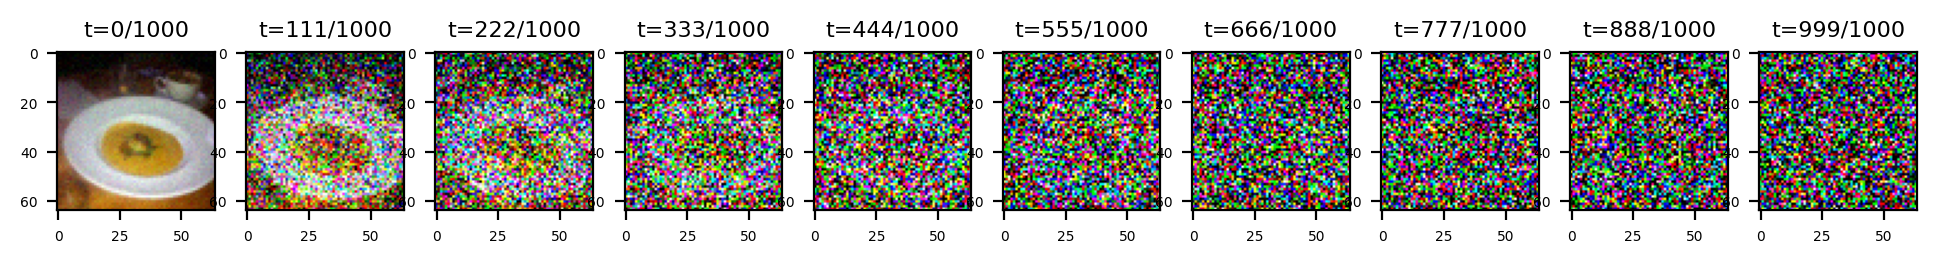

noise_rate:[0.5]


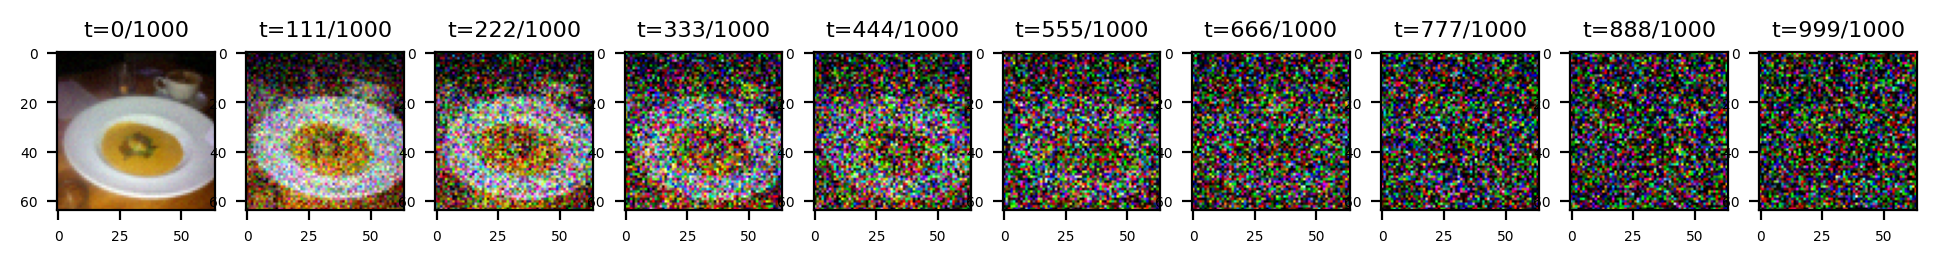

noise_rate:[0.0]


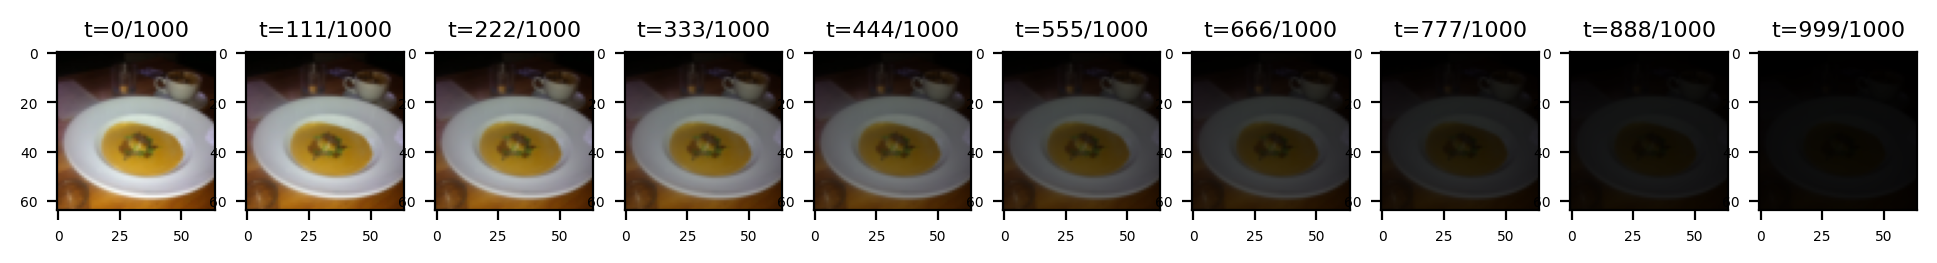

In [23]:
n_step = 10
x_0_batch = torch.tile(input=next(iter(dataloader))[0][0],dims=(n_step,1,1,1))
steps = torch.linspace(start=0,end=dc['T']-1,steps=n_step).type(torch.int64)
for noise_rate in [1.0,0.5,0.0]:
    print ("noise_rate:[%.1f]"%(noise_rate))
    x_t_tile,_ = forward_diffusion_sample(x_0=x_0_batch,steps=steps,dc=dc,noise_rate=noise_rate)
    # Plot 
    plt.figure(figsize=(12,2))
    for img_idx in range(n_step):
        plt.subplot(1,n_step,img_idx+1)
        plt.imshow(torch2np(x_t_tile[img_idx]).transpose([1,2,0]).clip(0.0,1.0))
        plt.title('t=%d/%d'%(torch2np(steps[img_idx]),dc['T']),fontsize=8)
    plt.show()

### Now, we move on to time-series data (1D trajectory)
When defining tensors, `B` comes first, followed by `D`, and `L` where `B` is the batch size, `D` is the dimension of a trajectory (often `D=1`) and `L` is the length of a trajectory.

In [24]:
from scipy.spatial import distance
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
print ("Ready.")

Ready.


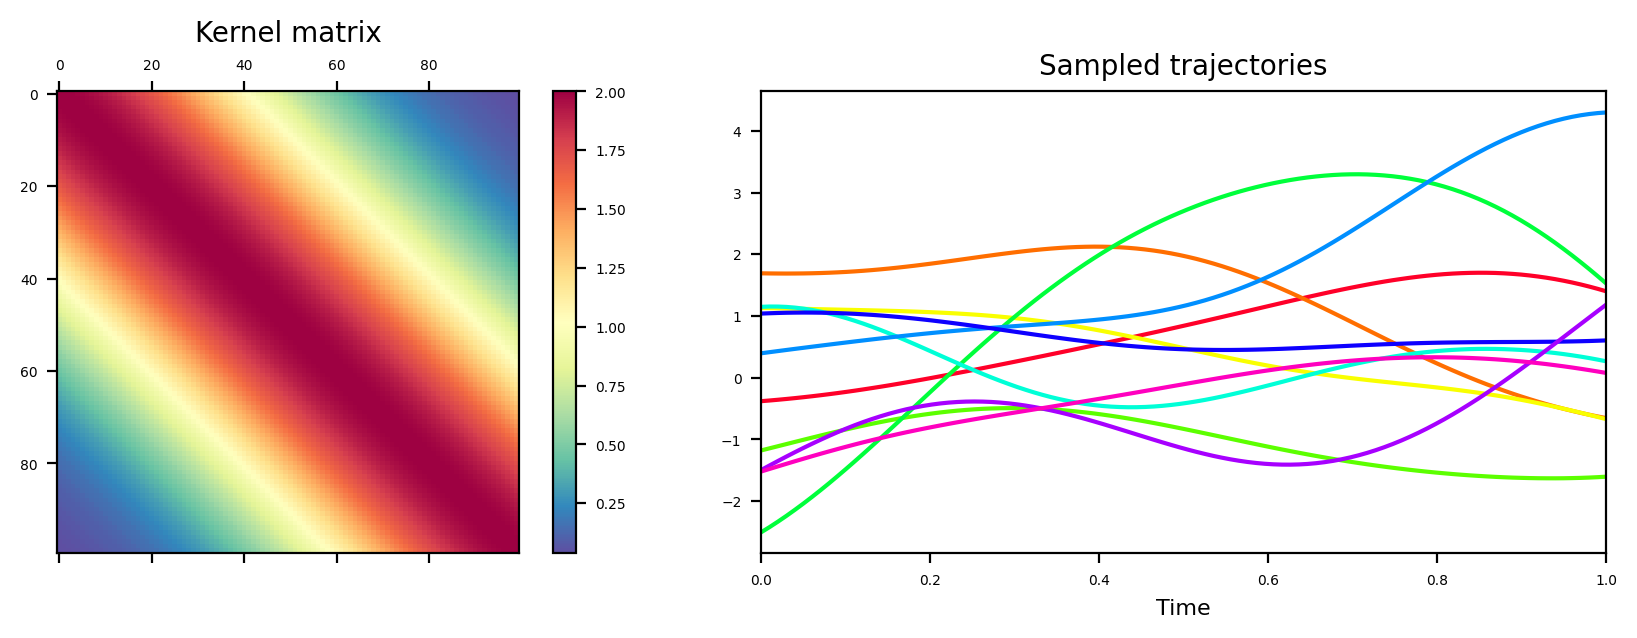

In [25]:
# Sample paths from Gaussian process prior
L = 100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K = kernel_se(times,times,hyp={'gain':2.0,'len':1/2})
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
D = 10
trajs = K_chol @ np.random.randn(L,D) # [L x D]
trajs = trajs.T # [D x L] <= we will be using this shape [D x L]
# Plot
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.matshow(K,fignum=False,cmap=plt.cm.Spectral_r)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Kernel matrix',fontsize=10)
plt.subplot(1,2,2)
colors = [plt.cm.gist_rainbow(_) for _ in np.linspace(0,1,D)]
for d_idx in range(D):
    traj,color = trajs[d_idx,:],colors[d_idx]
    plt.plot(times[:,0],traj,ls='-',color=color); 
plt.xlim([0,1])
plt.title('Sampled trajectories',fontsize=10)
plt.xlabel('Time',fontsize=8); plt.show()

### Plot how forward diffusion works

noise_rate:[1.0]


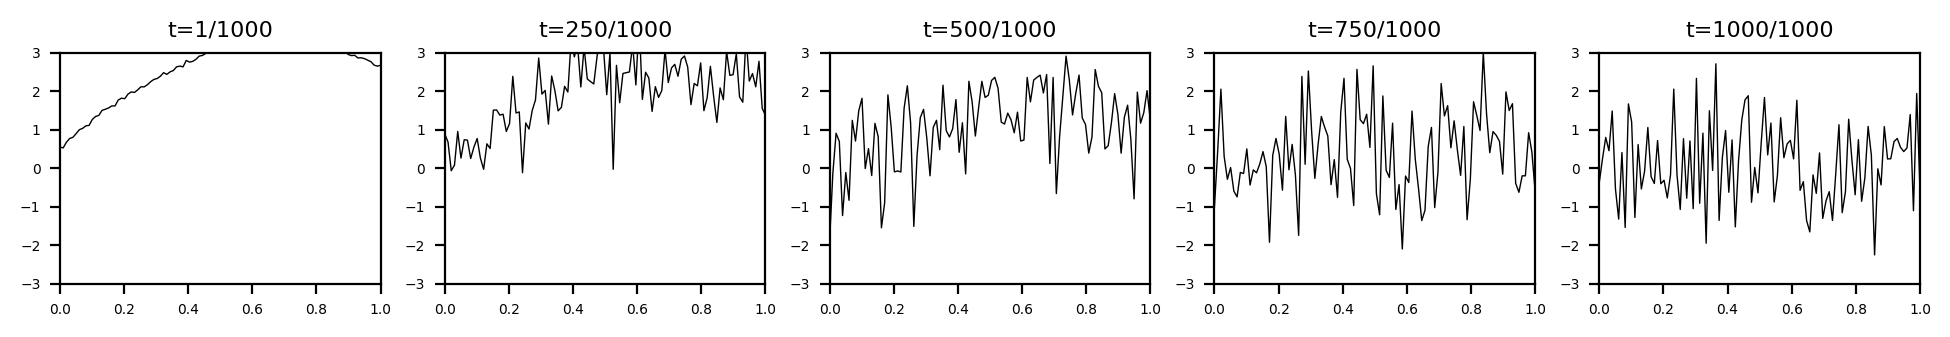

noise_rate:[0.5]


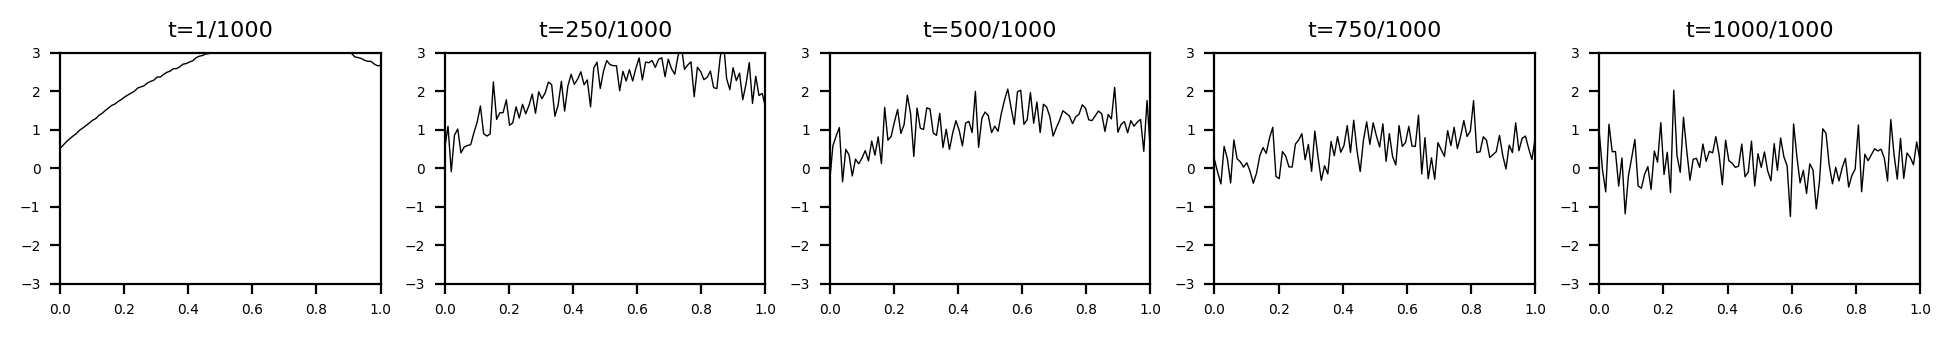

noise_rate:[0.0]


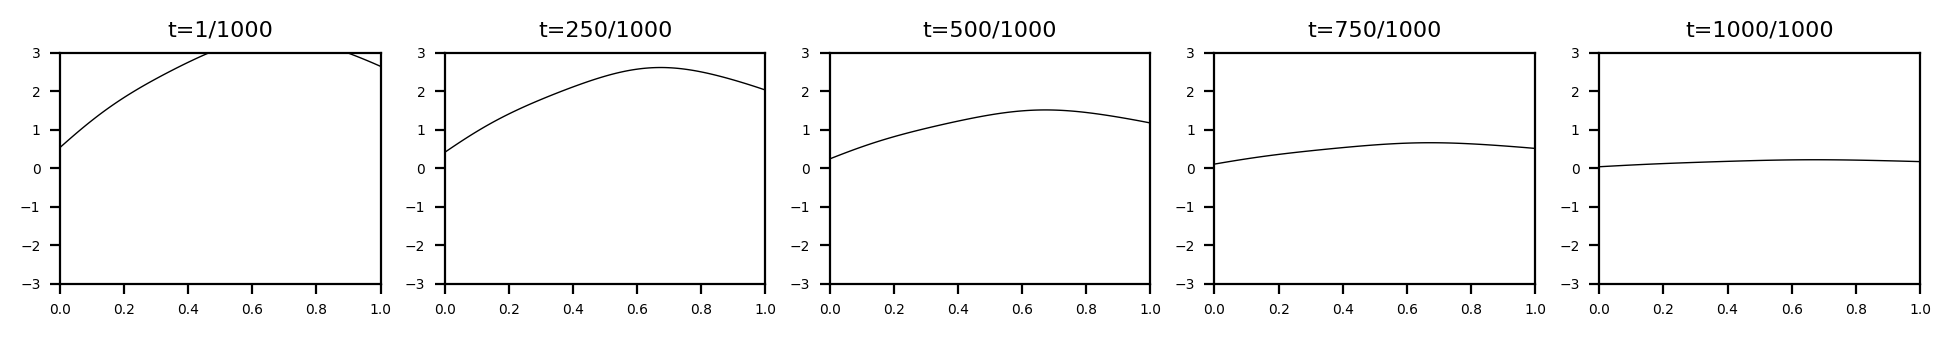

In [26]:
B,D = 5,1
trajs = K_chol @ np.random.randn(L,D) # [L x D]
trajs = trajs.T # [D x L]
x_0 = trajs[0:1,:] # [1 x L]
x_0_batch = np2torch(np.tile(x_0,reps=(B,1,1))) # [B x D x L]
steps = torch.linspace(start=0,end=dc['T']-1,steps=B).type(torch.int64) # [L]
for noise_rate in [1.0,0.5,0.0]:
    print ("noise_rate:[%.1f]"%(noise_rate))
    x_t_tile,_ = forward_diffusion_sample(x_0=x_0_batch,steps=steps,dc=dc,noise_rate=noise_rate) # [B x D x L]
    plt.figure(figsize=(12,1.5))
    for traj_idx in range(B):
        plt.subplot(1,B,traj_idx+1)
        plt.plot(times[:,0],torch2np(x_t_tile[traj_idx,0,:]),ls='-',color='k',lw=1/2)
        plt.xlim([0,1]); plt.ylim([-3.0,+3.0])
        plt.title('t=%d/%d'%(1+torch2np(steps[traj_idx]),dc['T']),fontsize=8)
    plt.show()

### Forward diffusion sampling from `Gaussian Process` using `batched matrix-matrix project`
[B x L x D] => [B x L x D] where the kernel matrix varies from one dimension to the other

B:[5] D:[4] L:[100]
torch.Size([5, 4, 100, 100]) torch.Size([5, 4, 100, 1])
Sampled trajectories from GP priors.


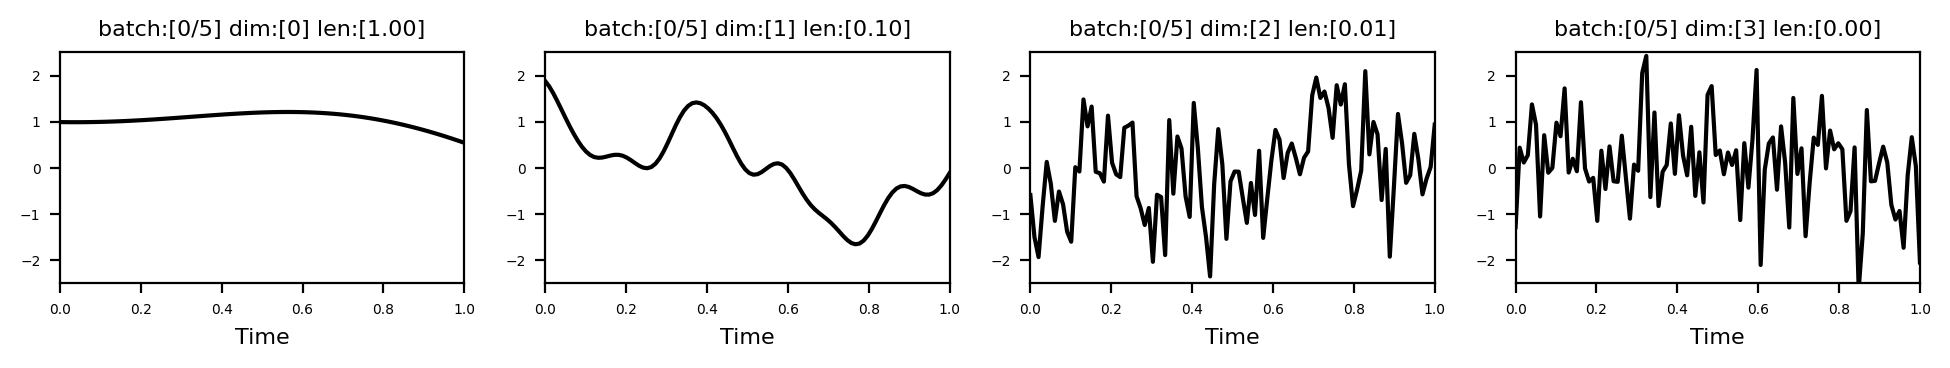

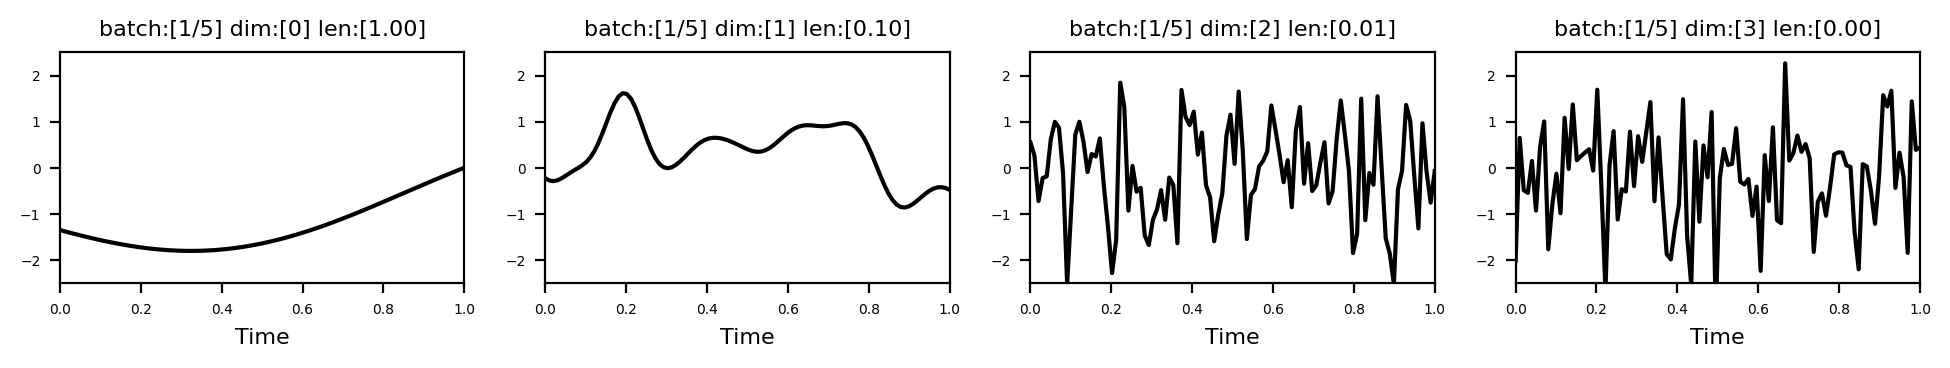

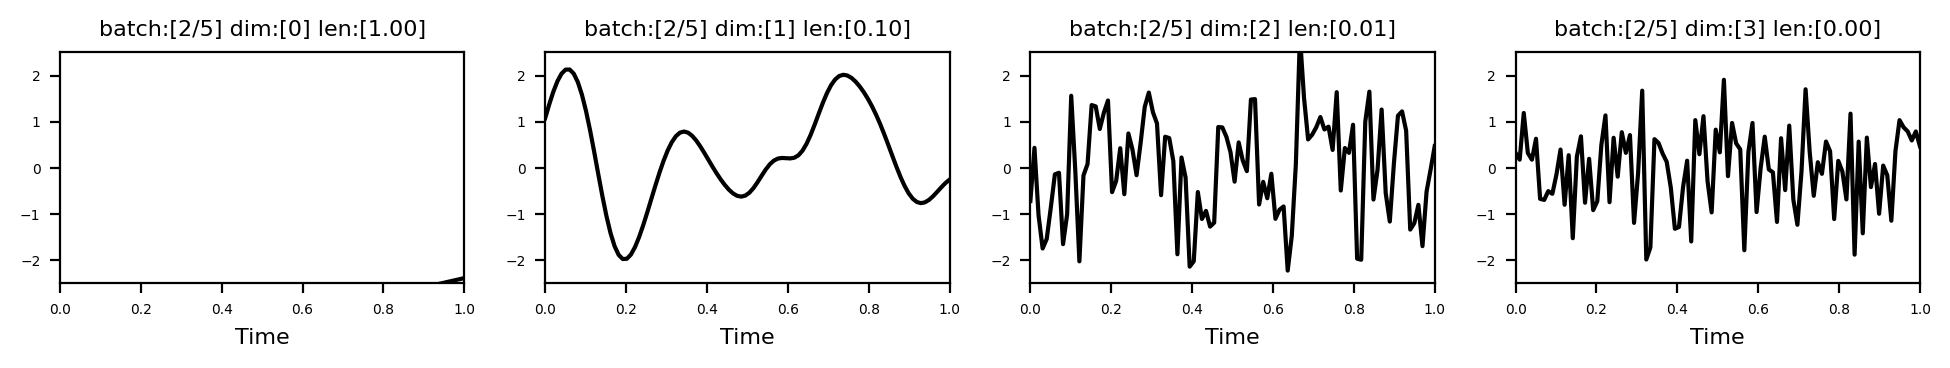

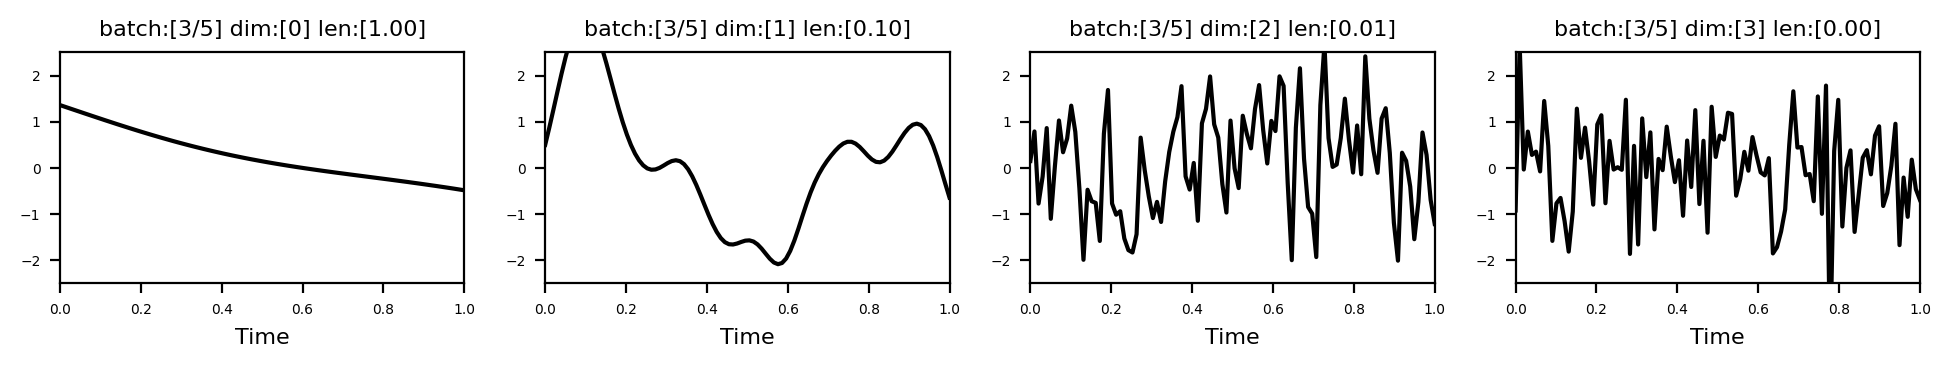

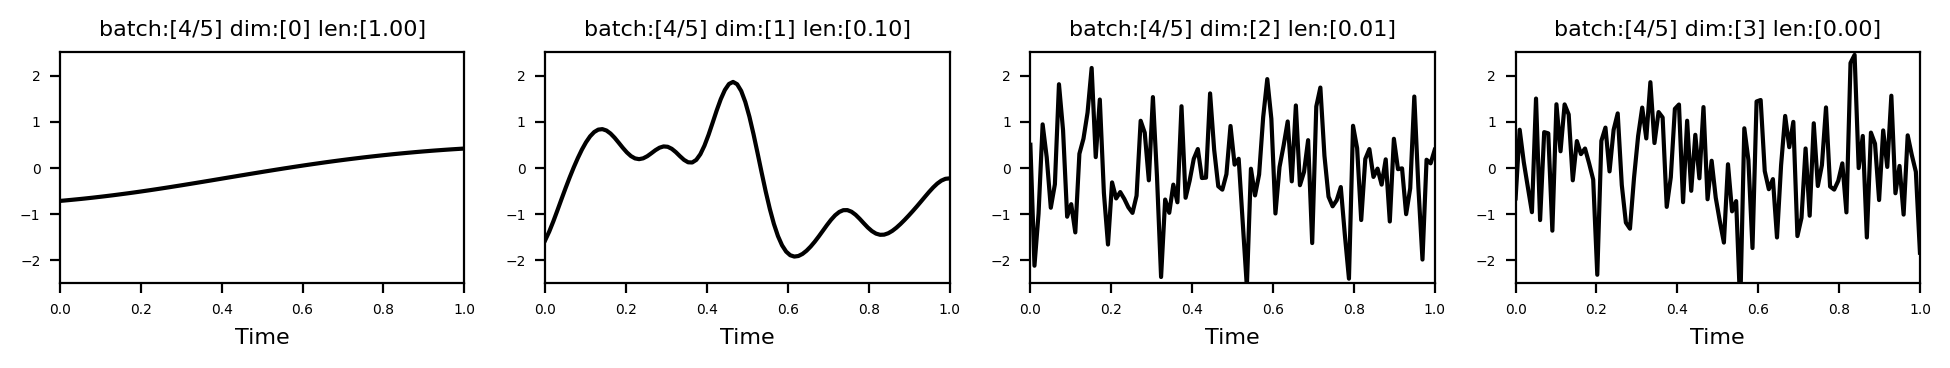

Ready.


In [27]:
B,D,L = 5,4,100
# Compute kernels
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K_chols = np.zeros(shape=(D,L,L)) # [D x L x L]
lens = [1,0.1,0.01,0.001]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]}) # [L x L]
    K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
    K_chols[d_idx,:,:] = K_chol
K_chols_torch = np2torch(K_chols) # [D x L x L]
K_chols_torch_tile = torch.tile(input=K_chols_torch,dims=(B,1,1,1)) # [B x D x L x L]
# Compute noise
noise = torch.randn(B,D,L) # [B x D x L]
noise_expand = noise[:,:,:,None] # [B x D x L x 1]
print ("B:[%d] D:[%d] L:[%d]"%(B,D,L))
print (K_chols_torch_tile.shape,noise_expand.shape)
# Batched matrix product: K_chols_torch_tile x noise_expand
# [B x D x L x L] x [B x D x L x 1] => [B x D x L x 1]
correlated_noise_permuted = K_chols_torch_tile @ noise_expand # [B x D x L x 1]
correlated_noise_squeeze = correlated_noise_permuted.squeeze(dim=3) # [B x D x L]
# Plot
print ("Sampled trajectories from GP priors.")
for b_idx in range(B):
    plt.figure(figsize=(12,1.5))
    for d_idx in range(D):
        plt.subplot(1,D,d_idx+1)
        plt.plot(times,torch2np(correlated_noise_squeeze[b_idx,d_idx,:]),ls='-',color='k')
        plt.xlim([0,+1]); plt.ylim([-2.5,+2.5])
        plt.title('batch:[%d/%d] dim:[%d] len:[%.2f]'%(b_idx,B,d_idx,lens[d_idx]),fontsize=8)
        plt.xlabel('Time',fontsize=8)
    plt.show()
print ("Ready.")

In [28]:
def forward_hilbert_diffusion_sample(x_0,K_chols,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x D x L]
        K_chols: torch.Tensor [D x L x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x D x L]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x D x L]
    # Correlated noise sampling 
    noise = torch.randn_like(input=x_0) # [B x D x L]
    noise_expand = noise[:,:,:,None] # [B x D x L x 1]
    K_chols_torch_tile = torch.tile(input=K_chols,dims=(x_0.shape[0],1,1,1)) # [B x D x L x L]
    correlated_noise_permuted = K_chols_torch_tile @ noise_expand # [B x D x L x 1]
    correlated_noise_squeeze = correlated_noise_permuted.squeeze(dim=3) # [B x D x L]
    # Sample with correlated noise
    x_t = x_t_mean + noise_rate*x_t_std*correlated_noise_squeeze # [B x D x L]
    return x_t,correlated_noise_squeeze # [B x D x L]
print ("Ready.")

Ready.


### Plot Hilbert forward diffusion

Plot ancestral sampling results.


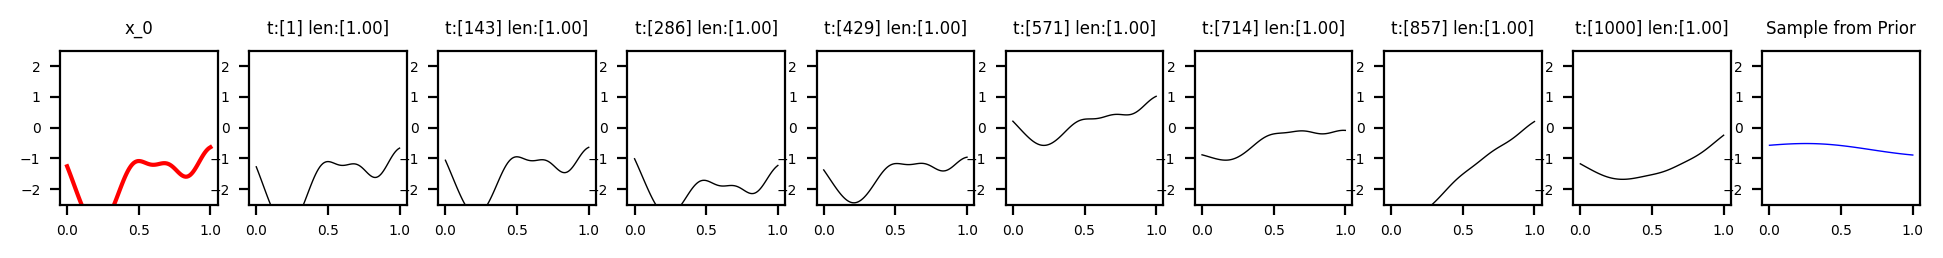

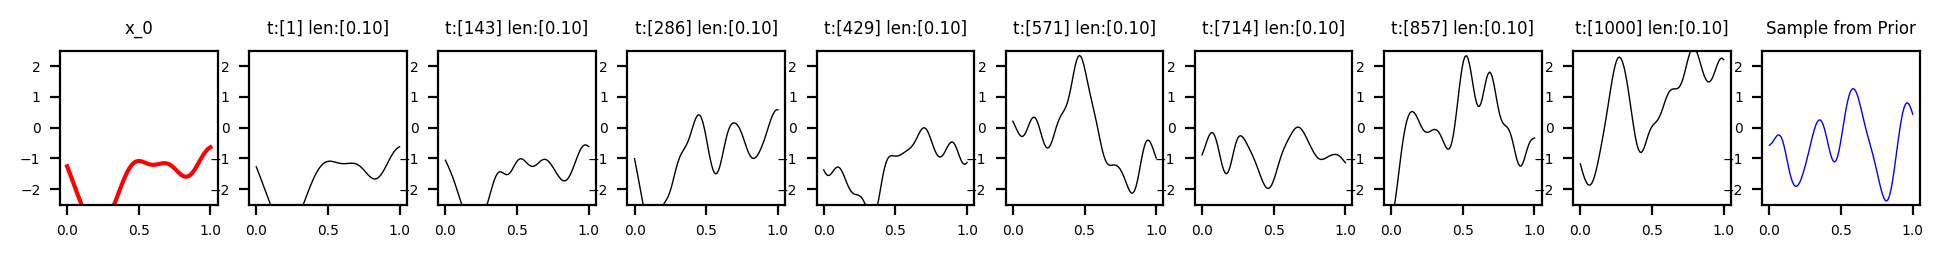

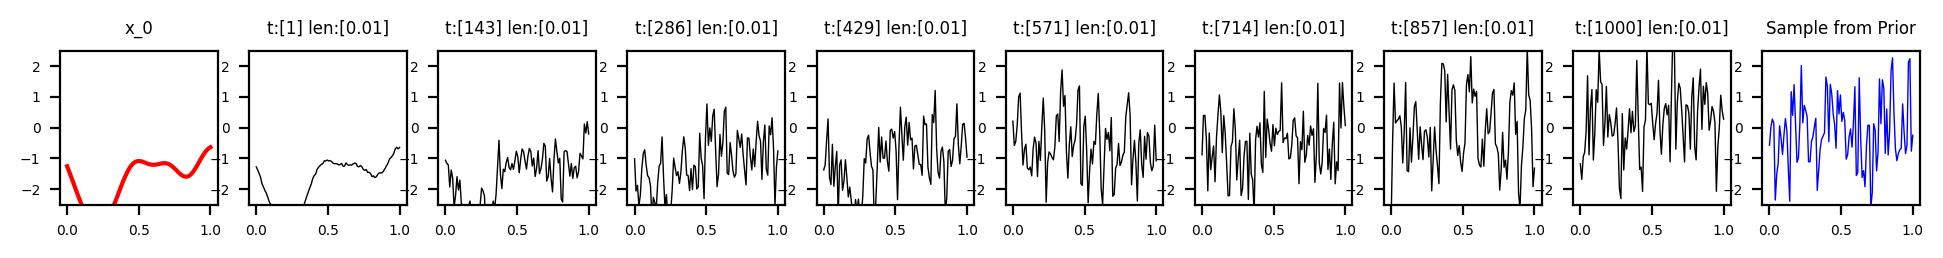

Plot correlated noise.


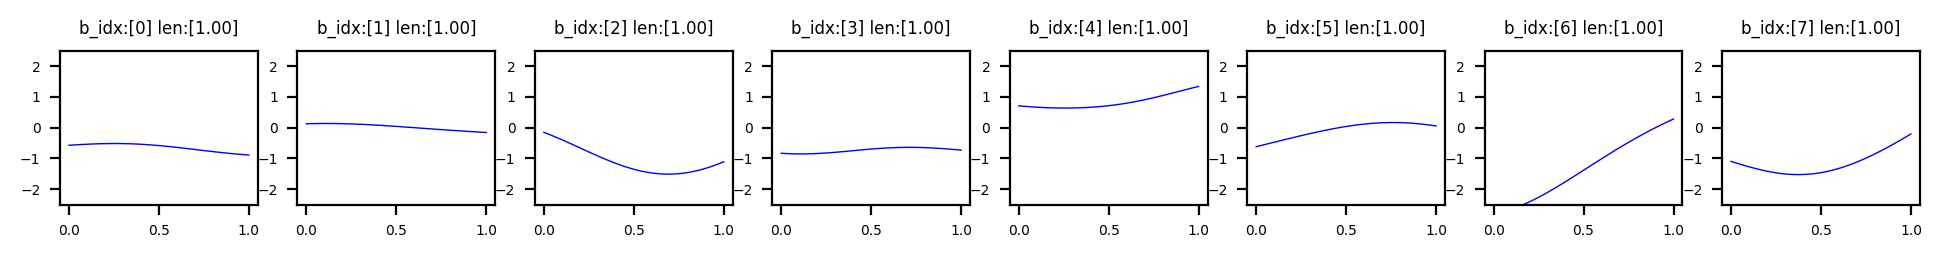

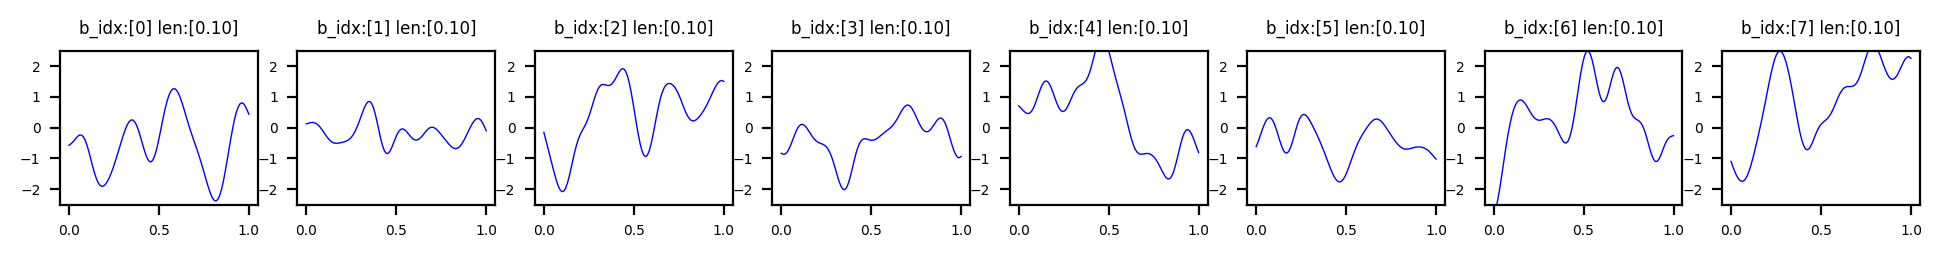

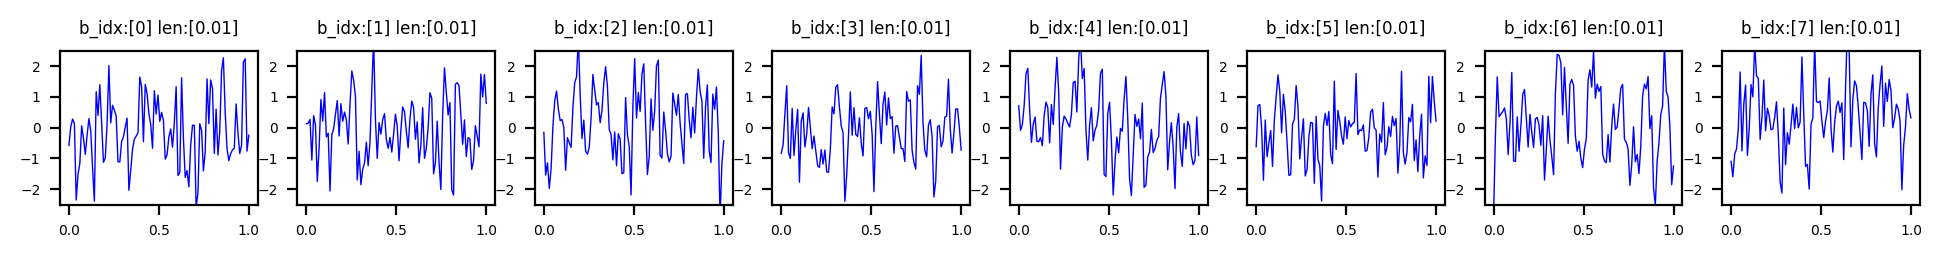

In [29]:
B,D,L = 8,3,100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
# Sample 'D' trajectories, but we will use only the first one
K = kernel_se(times,times,hyp={'gain':1.0,'len':0.2}) # [L x L]
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
trajs = K_chol @ np.random.randn(L,D) # [L x D]
trajs = trajs.T # [D x L]
# When constructing 'x_0_batch', we use the same trajectory and tile it
x_0 = np2torch(trajs[0:1,:]) # [1 x L]
x_0_batch = torch.tile(input=x_0[None,:,:],dims=(B,1,1)) # [B x 1 x L]
lens = [1,0.1,0.01]
K_chols = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]}) # [L x L]
    K_chols[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) 
K_chols_torch = np2torch(K_chols) # [D x L x L]
steps = torch.linspace(start=0,end=dc['T']-1,steps=B).type(torch.int64) # [B]
# Forward sampling of different kernels and diffusion steps at once
x_t,noise = forward_hilbert_diffusion_sample(
    x_0=x_0_batch,K_chols=K_chols_torch,steps=steps,dc=dc,noise_rate=1.0) # [B x D x L]
# Plot ancestral sampling results using hilbert diffusion
print ("Plot ancestral sampling results.")
for d_idx in range(D):
    plt.figure(figsize=(12,1))
    plt.subplot(1,B+2,1); plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='r')
    plt.ylim([-2.5,+2.5]); plt.title('x_0',fontsize=6)
    for b_idx in range(B):
        plt.subplot(1,B+2,b_idx+2); plt.plot(times[:,0],x_t[b_idx,d_idx,:],ls='-',color='k',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('t:[%d] len:[%.2f]'%(torch2np(steps)[b_idx]+1,lens[d_idx]),
                  fontsize=6)
    plt.subplot(1,B+2,B+2); plt.plot(times,torch2np(noise[0,d_idx,:]),ls='-',color='b',lw=1/2)
    plt.ylim([-2.5,+2.5]); plt.title('Sample from Prior',fontsize=6); plt.show()
# Plot correlated noises with different kernels 
print ("Plot correlated noise.")
for d_idx in range(D):
    plt.figure(figsize=(12,1))
    for b_idx in range(B):
        plt.subplot(1,B,b_idx+1)
        plt.plot(times[:,0],noise[b_idx,d_idx,:],ls='-',color='b',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('b_idx:[%d] len:[%.2f]'%(b_idx,lens[d_idx]),
                  fontsize=6)
    plt.show()